# Modelo de clasificación de Alopecia androgénica

Origen del dataset: hair-loss Classification Model by uze (2024). https://universe.roboflow.com/uze/hair-loss-nq8hh/dataset/1#.

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from PIL import Image

import torchvision
import torchvision.transforms as transforms

In [128]:
df_train = pd.read_csv('data/train/_classes.csv')
df_val = pd.read_csv('data/valid/_classes.csv')
df_test = pd.read_csv('data/test/_classes.csv')

df_train.head()

,filename,LEVEL_2,LEVEL_3,LEVEL_4,LEVEL_5,LEVEL_6,LEVEL_7
0,55-Front_jpg.rf.8e33204ae51619dbc14b2c05374a58...,0,1,0,0,0,0
1,27-Left_jpg.rf.9078d1b22afbfc8cef9a19dbed304c2...,0,0,1,0,0,0
2,39-Back_jpg.rf.8d7360446c976ce0e1419638d9f6003...,0,0,1,0,0,0
3,23-Front_jpg.rf.8fc70587a0b731a859bfe4cdd11784...,0,0,0,1,0,0
4,29-Left_jpg.rf.8f3d12809a8662891b1a02d4578c5cb...,0,0,0,0,1,0


In [129]:
df_train.info()
df_val.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1294 non-null   object
 1    LEVEL_2  1294 non-null   int64 
 2    LEVEL_3  1294 non-null   int64 
 3    LEVEL_4  1294 non-null   int64 
 4    LEVEL_5  1294 non-null   int64 
 5    LEVEL_6  1294 non-null   int64 
 6    LEVEL_7  1294 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 70.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  133 non-null    object
 1    LEVEL_2  133 non-null    int64 
 2    LEVEL_3  133 non-null    int64 
 3    LEVEL_4  133 non-null    int64 
 4    LEVEL_5  133 non-null    int64 
 5    LEVEL_6  133 non-null    int64 
 6    LEVEL_7  133 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 7.4+ KB
<clas

In [130]:
print(df_train.isnull().sum().sum())
print(df_val.isnull().sum().sum())
print(df_test.isnull().sum().sum())

0
0
0


**Findings**  
None of the three datasets contain any null values.

In [131]:
def plot_value_counts(df, column, ax_num, title):
    cols = df.columns.tolist()
    cols.remove(column)

    counts = df[cols].sum()
    sns.barplot(x=counts.index, y=counts.values, palette='terrain', hue=counts.index, ax=ax_num)
    ax_num.set_xlabel(column)
    ax_num.set_ylabel('Count')
    ax_num.set_title(title)

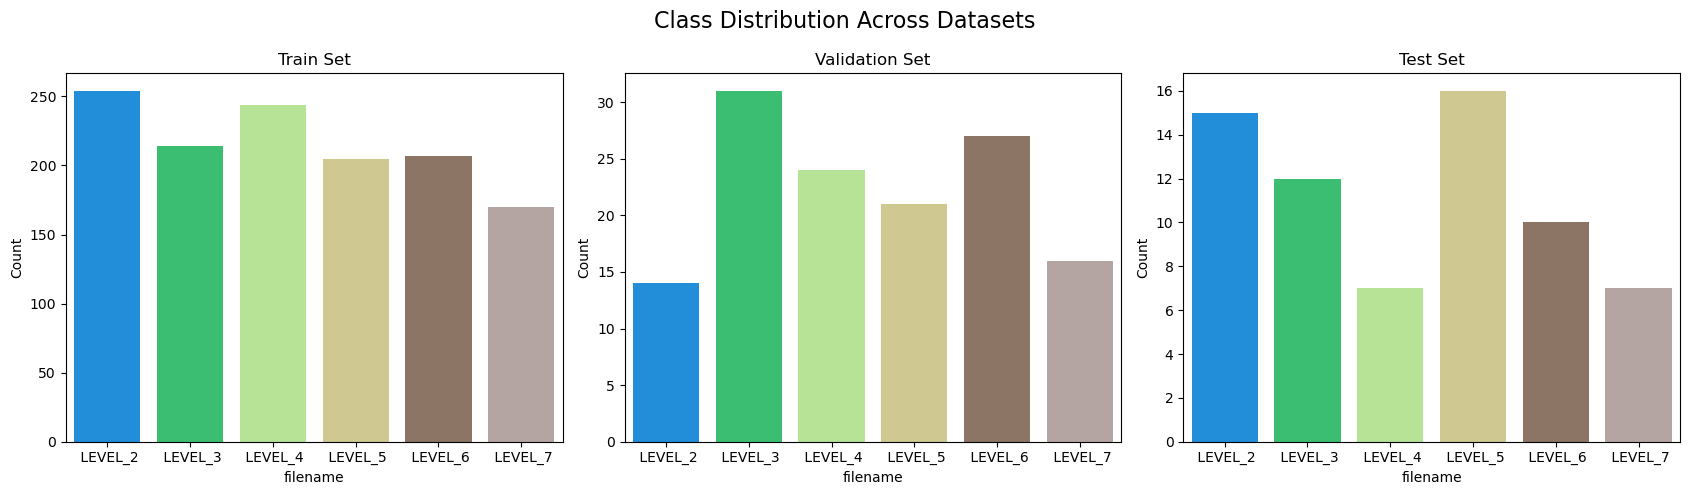

In [132]:
fig, ax = plt.subplot_mosaic(
    mosaic=[[0, 1, 2]],
    figsize=(17, 5)
)
plot_value_counts(df_train, 'filename', ax[0], 'Train Set')
plot_value_counts(df_val, 'filename', ax[1], 'Validation Set')
plot_value_counts(df_test, 'filename', ax[2], 'Test Set')
plt.suptitle('Class Distribution Across Datasets', fontsize=16)
plt.tight_layout()
plt.show()

**Findings**  
While the train set has balanced labels, both validation and test set don't, having the most common class more than twice the size of the rarest.

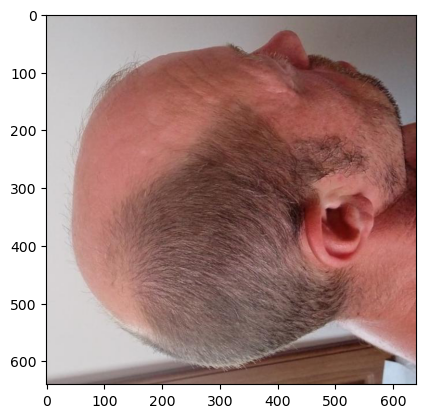

In [133]:
img = Image.open("data/train/" + df_train["filename"][np.random.randint(len(df_train))])
plt.imshow(img)

**Findings**  
Images from the training set had already been augmented by fliping them both horizontally and vertically

In [134]:
# Tarda unos minutos en ejecutarse, no da error de assertion
'''
for i in range(len(df_train)):
    img = Image.open(f'data/train/{df_train["filename"][i]}')
    assert img.shape == (640, 640, 3), f"Image at index {i} has shape {img.shape}, expected (640, 640, 3)"

for i in range(len(df_val)):
    img = Image.open(f'data/valid/{df_val["filename"][i]}')
    assert img.shape == (640, 640, 3), f"Image at index {i} has shape {img.shape}, expected (640, 640, 3)"

for i in range(len(df_test)):
    img = Image.open(f'data/test/{df_test["filename"][i]}')
    assert img.shape == (640, 640, 3), f"Image at index {i} has shape {img.shape}, expected (640, 640, 3)"
'''

'\nfor i in range(len(df_train)):\n    img = Image.open(f\'data/train/{df_train["filename"][i]}\')\n    assert img.shape == (640, 640, 3), f"Image at index {i} has shape {img.shape}, expected (640, 640, 3)"\n\nfor i in range(len(df_val)):\n    img = Image.open(f\'data/valid/{df_val["filename"][i]}\')\n    assert img.shape == (640, 640, 3), f"Image at index {i} has shape {img.shape}, expected (640, 640, 3)"\n\nfor i in range(len(df_test)):\n    img = Image.open(f\'data/test/{df_test["filename"][i]}\')\n    assert img.shape == (640, 640, 3), f"Image at index {i} has shape {img.shape}, expected (640, 640, 3)"\n'

**Findings**  
All images have the same size and are RGB

In [135]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

X_train_tensor = torch.stack([transform(Image.open(f'data/train/{fname}')) for fname in df_train['filename']])
y_train_tensor = torch.tensor(df_train.drop(columns=['filename']).values, dtype=torch.float32)

X_train_tensor.shape, y_train_tensor.shape

(torch.Size([1294, 3, 640, 640]), torch.Size([1294, 6]))

In [136]:
X_val_tensor = torch.stack([transform(Image.open(f'data/valid/{fname}')) for fname in df_val['filename']])
y_val_tensor = torch.tensor(df_val.drop(columns=['filename']).values, dtype=torch.float32)

X_test_tensor = torch.stack([transform(Image.open(f'data/test/{fname}')) for fname in df_test['filename']])
y_test_tensor = torch.tensor(df_test.drop(columns=['filename']).values, dtype=torch.float32)

In [137]:
Train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
Val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
Test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

Train_dataset[:][0].shape, Train_dataset[:][1].shape

(torch.Size([1294, 3, 640, 640]), torch.Size([1294, 6]))